## 1.Loading the packages

In [16]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
from sklearn.metrics import recall_score,precision_score,f1_score,top_k_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pandas as pd


## 2.The Dataset

In [17]:
X_train = np.load('train_data.npy')
y_train = np.load('train_label.npy')
y_train = y_train.flatten()
X_test = np.load('test_data.npy')
y_test = np.load('test_label.npy')
y_test = y_test.flatten()

In [18]:
def check_nan_inf(data, name):
    print(f"检查 {name}...")
    if np.isnan(data).any():
        print(f"{name} 包含 NaN 值.")
    else:
        print(f"{name} 不包含 NaN 值.")

    if np.isinf(data).any():
        print(f"{name} 包含 Inf 值.")
    else:
        print(f"{name} 不包含 Inf 值.")

# 检查极端值
def check_extreme_values(data, name):
    print(f"检查 {name} 的极端值...")
    print(f"{name} 最大值: {np.max(data)}")
    print(f"{name} 最小值: {np.min(data)}")

# 对所有数据集执行检查
for data, name in zip([X_train, y_train, X_test, y_test], ['X_train', 'y_train', 'X_test', 'y_test']):
    check_nan_inf(data, name)
    check_extreme_values(data, name)
    print("\n")

检查 X_train...
X_train 不包含 NaN 值.
X_train 不包含 Inf 值.
检查 X_train 的极端值...
X_train 最大值: 25.581360537720347
X_train 最小值: -23.41520966868848


检查 y_train...
y_train 不包含 NaN 值.
y_train 不包含 Inf 值.
检查 y_train 的极端值...
y_train 最大值: 9
y_train 最小值: 0


检查 X_test...
X_test 不包含 NaN 值.
X_test 不包含 Inf 值.
检查 X_test 的极端值...
X_test 最大值: 25.403761341192112
X_test 最小值: -21.369402789797963


检查 y_test...
y_test 不包含 NaN 值.
y_test 不包含 Inf 值.
检查 y_test 的极端值...
y_test 最大值: 9
y_test 最小值: 0




## 3.Normalization

In [19]:
def min_max_normalize(X, X_min, X_max):
    return (X - X_min) / (X_max - X_min)

def z_score_normalize(X):
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_std[X_std == 0] = 1  # 防止除以0
    X_norm = (X - X_mean) / X_std
    return X_norm

# 计算训练数据的最小值和最大值
X_train_min = np.min(X_train, axis=0)
X_train_max = np.max(X_train, axis=0)

X_test_min = np.min(X_test, axis=0)
X_test_max = np.max(X_test, axis=0)

# 使用训练数据的最小值和最大值来归一化训练数据和测试数据
X_train = z_score_normalize(X_train)
X_test = z_score_normalize(X_test)

# # 检查归一化后的数据
# print("归一化后的 X_train 最大值:", np.max(X_train_normalized))
# print("归一化后的 X_train 最小值:", np.min(X_train_normalized))
# print("归一化后的 X_test 最大值:", np.max(X_test_normalized))
# print("归一化后的 X_test 最小值:", np.min(X_test_normalized))

## 4.Activation

In [20]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        return 1.0 - a**2

    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        return a * (1 - a)

    def __relu(self, x):
        return np.maximum(0, x)

    def __relu_deriv(self, a):
        return np.where(a > 0, 1, 0)

    def __gelu(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

    def __gelu_deriv(self, a):
        # 这里提供一个简化的 GELU 导数近似
        # 注意：这不是精确的导数，但可以用于某些场景
        return 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (a + 0.044715 * np.power(a, 3)))) + \
               0.5 * a * (1 - np.tanh(np.sqrt(2 / np.pi) * (a + 0.044715 * np.power(a, 3)))**2) * \
               (np.sqrt(2 / np.pi) * (1 + 3 * 0.044715 * np.power(a, 2)))

    def __softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)


    def __init__(self, activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'gelu':
            self.f = self.__gelu
            self.f_deriv = self.__gelu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = None
        elif activation ==None:
            self.f = None
            self.f_deriv = None
        else:
            raise ValueError("Unknown activation function.")

## 5.HiddenLayer

$$output = f\_act(\sum_{i=0}^{1}{(I_{i} * W_{i})} + b)$$

In [21]:
class BatchNormLayer:
    def __init__(self, n_out, momentum=0.9):
        self.gamma = np.ones(n_out)
        self.beta = np.zeros(n_out)
        self.epsilon = 1e-5
        self.momentum = momentum
        self.running_mean = np.zeros(n_out)
        self.running_var = np.ones(n_out)

    def forward(self, input, is_training):
        if is_training:
            batch_mean = np.mean(input, axis=0)
            batch_var = np.var(input, axis=0)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var

            self.normalized = (input - batch_mean) / np.sqrt(batch_var + self.epsilon)
            out = self.gamma * self.normalized + self.beta
            self.input = input
            return out
        else:
            normalized = (input - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * normalized + self.beta
            return out

    def backward(self, delta):
        N, D = delta.shape

        # 计算gamma的梯度
        dgamma = np.sum(delta * self.normalized, axis=0)
        dbeta = np.sum(delta, axis=0)

        # 计算传递给前一层的梯度
        dnormalized = delta * self.gamma
        dinput = (1. / N) / np.sqrt(self.running_var + self.epsilon) * (
            N * dnormalized - np.sum(dnormalized, axis=0) - 
            self.normalized * np.sum(dnormalized * self.normalized, axis=0)
        )
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dinput

In [22]:
class HiddenLayer(object):
    def __init__(self, n_in, n_out,last_activation='relu' ,activation='relu', W=None, b=None, rng=None, dropout_rate=0.0):
        """
        初始化隐藏层
        """
        self.input = None
        self.activation = Activation(activation).f
        self.activation_deriv=None
        if last_activation:
            self.activation_deriv=Activation(last_activation).f_deriv
        self.dropout_rate = dropout_rate
        self.mask = None  # Dropout mask
                
        rng = np.random.RandomState(1234)

        # 初始化权重和偏置
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = rng.uniform(low=-a, high=a, size=(n_in, n_out))
        self.b = np.zeros(n_out,)

        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        # 用于动量SGD的速度初始化
        self.velocity_W = np.zeros(self.W.shape)
        self.velocity_b = np.zeros(self.b.shape)

    def forward(self, input, is_training=False):
        """
        前向传播
        """
        rng = np.random.RandomState(1234)
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input = input

        # 应用 Dropout
        if is_training and self.dropout_rate > 0:
            self.mask = rng.binomial(n=1, p=1-self.dropout_rate, size=self.output.shape)
            self.output *= self.mask           
        
        return self.output

    def backward(self, delta, weight_decay=0.0001):
        """
        反向传播
        """    
        if self.mask is not None:
            delta = delta*self.mask  # Apply Dropout
            
        self.grad_W = np.dot(self.input.T, delta) - weight_decay * self.W
        self.grad_b = np.sum(delta, axis=0)

        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        
        return delta

## 6.The MLP

The class implements a MLP with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner.

In [23]:
class MLP:
    def __init__(self, layers, activations=[None,'relu','relu','relu','relu',None], dropout_rates=None,use_batchNorm=True):
        self.layers = []
        self.params = []
        self.activations = activations
        self.use_batchNorm = use_batchNorm
        if dropout_rates is None:
            dropout_rates = [0.0] * len(layers)
        for i in range(len(layers) - 1):
            self.layers.append(HiddenLayer(layers[i], layers[i+1], last_activation=activations[i],activation=activations[i+1], dropout_rate=dropout_rates[i]))
            if use_batchNorm:
                self.layers.append(BatchNormLayer(layers[i+1]))


    def forward(self, input,is_training = False):
        for layer in self.layers:
            input = layer.forward(input,is_training = is_training)
        return input

    def softmax_cross_entropy(self,y, y_hat):
        # 计算每个样本的log-sum-exp
        log_sum_exp = np.log(np.sum(np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True)), axis=1, keepdims=True))
        
        # 计算Softmax概率
        softmax_probs = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True)) / np.exp(log_sum_exp)
        
        # 计算稳定的交叉熵损失
        loss =  -np.sum(y * np.log(softmax_probs)) / y.shape[0]
        # 计算梯度
        delta = (softmax_probs - y) / y.shape[0]
        return loss, delta

    def update(self, lr, weight_decay=0.0001, momentum=0.9):
        for layer in self.layers:
            # 计算带权重衰减的梯度
            if isinstance(layer,HiddenLayer):
            
                if not hasattr(layer, 'velocity_W'):

                    layer.velocity_W = np.zeros_like(layer.W)
                    layer.velocity_b = np.zeros_like(layer.b)

                grad_W_with_weight_decay = layer.grad_W + weight_decay * layer.W

                # 更新动量
                layer.velocity_W = momentum * layer.velocity_W + lr * grad_W_with_weight_decay
                layer.velocity_b = momentum * layer.velocity_b + lr * layer.grad_b

                # 应用更新
                layer.W -= layer.velocity_W
                layer.b -= layer.velocity_b
            
            if isinstance(layer,BatchNormLayer):
                layer.gamma -= lr * layer.dgamma
                layer.beta -= lr * layer.dbeta
                
                
    
    
    def fit(self, X, y, y_train, X_test, y_test, learning_rate=0.1, epochs=100, batch_size=32, weight_decay=0.0001, momentum=0.9):
        X = np.array(X)
        y = np.array(y)
        train_top1_acc_metrics = []
        train_recall_score_metrics = []
        train_f1_score_metrics = []
        train_precision_score_metrics = []

        losses=np.zeros(epochs)
        test_top1_acc_metrics = []
        test_recall_score_metrics = []
        test_f1_score_metrics = []
        test_precision_score_metrics = []
        for k in range(epochs):
            loss = 0.0
            idx=0
            for start in range(0, X.shape[0], batch_size):
                idx +=1
                end = start + batch_size
                X_batch = X[start:end]
                y_batch = y[start:end]

                # Forward pass
                y_hat = self.forward(X_batch, is_training=True)

                # Compute loss
                batch_loss, delta = self.softmax_cross_entropy(y_batch, y_hat)
                loss += batch_loss

                # Backward pass and update
                self.backward(delta,weight_decay=weight_decay)
                self.update(learning_rate, weight_decay=weight_decay, momentum=momentum)

                
                
            losses[k] = loss / idx
            
            
            
             # 计算训练集准确率
            y_pred_train = self.predict(X)
            train_accuracy = np.mean(y_pred_train == y_train)
            
            
            train_top1_acc_metrics.append(train_accuracy)
            train_recall_score_metrics.append(recall_score(y_train,y_pred_train,average='macro'))
            train_f1_score_metrics.append(f1_score(y_train,y_pred_train,average='macro'))
            train_precision_score_metrics.append(precision_score(y_train,y_pred_train,average='macro')) 
            
            # 计算测试集准确率
            y_pred_test = self.predict(X_test)
            test_accuracy = np.mean(y_pred_test == y_test)
            
            test_top1_acc_metrics.append(test_accuracy)
            test_recall_score_metrics.append(recall_score(y_test,y_pred_test,average='macro'))
            test_f1_score_metrics.append(f1_score(y_test,y_pred_test,average='macro'))
            test_precision_score_metrics.append(precision_score(y_test,y_pred_test,average='macro')) 
            
            print(f"Epoch {k+1}/{epochs}: Loss: {losses[k]:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")
            
        return losses,train_top1_acc_metrics,train_recall_score_metrics, train_f1_score_metrics,train_precision_score_metrics,\
test_top1_acc_metrics,test_recall_score_metrics,test_f1_score_metrics, test_precision_score_metrics

    
    # backward progress
    def backward(self, delta,weight_decay):
        # 假设最后一层是特殊处理，但不通过 output_layer 参数来区分
        for layer in reversed(self.layers):
            if isinstance(layer,BatchNormLayer):
                delta = layer.backward(delta)
            else:
                delta = layer.backward(delta, weight_decay=weight_decay)
        

    def predict(self, x):
        x = np.array(x)
        output = self.forward(x, is_training=False)
        return output.argmax(axis=1)
    
    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

## 7.超参数调优

## 7.1.layers 

In [24]:
# 假设y_train, y_test已经定义
num_classes = np.unique(y_train).size
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

# 定义不同的隐藏层配置
hidden_layers_configs = {
    '2_layers': [68, 128, num_classes],
    '3_layers': [68, 128, 128, num_classes],
    '4_layers': [68, 128, 128, 69, num_classes]
}

# 用于存储每种配置的结果
results = {}

for config_name, layers in hidden_layers_configs.items():
    print(f"Testing configuration: {config_name}")
    # 初始化MLP模型
    nn = MLP(layers=[X_train.shape[1]] + layers, 
             activations=[None] + ['gelu'] * (len(layers) - 1) + [None], 
             dropout_rates=[0.0] + [0.2] * (len(layers) - 2) + [0.0, 0.0])

    start_time = time.time()
    # 训练模型
    losses,train_top1_acc_metrics,train_recall_score_metrics, train_f1_score_metrics,train_precision_score_metrics,\
test_top1_acc_metrics,test_recall_score_metrics,test_f1_score_metrics, test_precision_score_metrics \
    = nn.fit(X=X_train, y=y_train_one_hot, y_train=y_train, X_test=X_test, y_test=y_test, 
                    learning_rate=0.01, epochs=20, batch_size=32, weight_decay=0.001, momentum=0.9)
    end_time = time.time()

    print(f"执行时间: {end_time - start_time}秒")

    # 计算训练集上的准确率
    y_pred_train = nn.predict(X_train)
    train_accuracy = np.mean(y_pred_train == y_train)
    print(f"训练集准确率: {train_accuracy * 100:.2f}%")

    # 计算测试集上的准确率
    y_pred_test = nn.predict(X_test)
    test_accuracy = np.mean(y_pred_test == y_test)
    print(f"测试集准确率: {test_accuracy * 100:.2f}%")

    # 保存结果
    results[config_name] = {
        'train_accuracy': train_top1_acc_metrics,
        'test_accuracy': test_top1_acc_metrics,
        'execution_time': end_time - start_time
    }


Testing configuration: 2_layers
Epoch 1/20: Loss: 1.8541 - Train Accuracy: 0.4391 - Test Accuracy: 0.4255
Epoch 2/20: Loss: 1.6091 - Train Accuracy: 0.4861 - Test Accuracy: 0.4583
Epoch 3/20: Loss: 1.5164 - Train Accuracy: 0.5109 - Test Accuracy: 0.4761
Epoch 4/20: Loss: 1.4561 - Train Accuracy: 0.5286 - Test Accuracy: 0.4856
Epoch 5/20: Loss: 1.4129 - Train Accuracy: 0.5386 - Test Accuracy: 0.4914
Epoch 6/20: Loss: 1.3806 - Train Accuracy: 0.5456 - Test Accuracy: 0.4948
Epoch 7/20: Loss: 1.3552 - Train Accuracy: 0.5523 - Test Accuracy: 0.4972
Epoch 8/20: Loss: 1.3344 - Train Accuracy: 0.5575 - Test Accuracy: 0.4982
Epoch 9/20: Loss: 1.3172 - Train Accuracy: 0.5612 - Test Accuracy: 0.4991
Epoch 10/20: Loss: 1.3028 - Train Accuracy: 0.5634 - Test Accuracy: 0.5008
Epoch 11/20: Loss: 1.2903 - Train Accuracy: 0.5650 - Test Accuracy: 0.5012
Epoch 12/20: Loss: 1.2793 - Train Accuracy: 0.5676 - Test Accuracy: 0.4990
Epoch 13/20: Loss: 1.2696 - Train Accuracy: 0.5696 - Test Accuracy: 0.4977
Ep

In [25]:
# 打印所有配置的结果
for config_name, metrics in results.items():
    print(f"{config_name}: train accuracy={metrics['train_accuracy'][-1] * 100:.2f}%, test accuracy={metrics['test_accuracy'][-1] * 100:.2f}%, run time={metrics['execution_time']}秒")

2_layers: train accuracy=57.50%, test accuracy=49.54%, run time=92.29929208755493秒
3_layers: train accuracy=54.34%, test accuracy=46.69%, run time=140.28919291496277秒
4_layers: train accuracy=51.41%, test accuracy=45.16%, run time=173.03320240974426秒


Text(0.5, 0, 'Epochs')

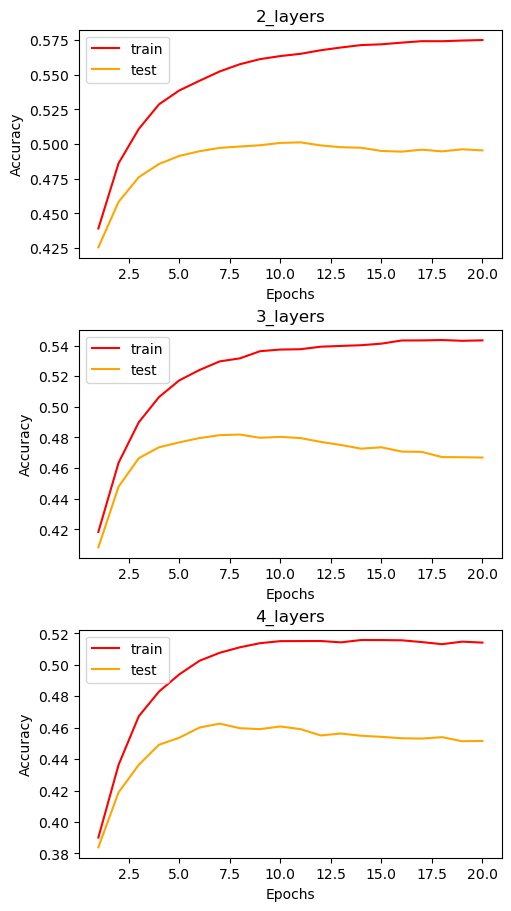

In [26]:
epochs=range(1,len(results['2_layers']['train_accuracy'])+1)

fig,ax =plt.subplots(3,constrained_layout=True, figsize=(5, 9))

ax[0].plot(epochs, results['2_layers']['train_accuracy'], color="red", label='train')
ax[0].plot(epochs, results['2_layers']['test_accuracy'], color="orange", label='test')
ax[0].set_title("2_layers")
ax[0].legend()
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, results['3_layers']['train_accuracy'], color="red", label='train')
ax[1].plot(epochs, results['3_layers']['test_accuracy'], color="orange", label='test')
ax[1].legend()
ax[1].set_title("3_layers")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")

ax[2].plot(epochs, results['4_layers']['train_accuracy'], color="red", label='train')
ax[2].plot(epochs, results['4_layers']['test_accuracy'], color="orange", label='test')
ax[2].legend()
ax[2].set_title("4_layers")
ax[2].set_ylabel("Accuracy")
ax[2].set_xlabel("Epochs")

## 7.2.gelu and relu

Testing model with activation function: relu
Epoch 1/20: Loss: 1.8918 - Train Accuracy: 0.4290 - Test Accuracy: 0.4142
Epoch 2/20: Loss: 1.6364 - Train Accuracy: 0.4747 - Test Accuracy: 0.4528
Epoch 3/20: Loss: 1.5426 - Train Accuracy: 0.5000 - Test Accuracy: 0.4713
Epoch 4/20: Loss: 1.4818 - Train Accuracy: 0.5165 - Test Accuracy: 0.4813
Epoch 5/20: Loss: 1.4397 - Train Accuracy: 0.5261 - Test Accuracy: 0.4876
Epoch 6/20: Loss: 1.4067 - Train Accuracy: 0.5331 - Test Accuracy: 0.4910
Epoch 7/20: Loss: 1.3805 - Train Accuracy: 0.5415 - Test Accuracy: 0.4935
Epoch 8/20: Loss: 1.3592 - Train Accuracy: 0.5456 - Test Accuracy: 0.4962
Epoch 9/20: Loss: 1.3414 - Train Accuracy: 0.5509 - Test Accuracy: 0.4993
Epoch 10/20: Loss: 1.3256 - Train Accuracy: 0.5522 - Test Accuracy: 0.4987
Epoch 11/20: Loss: 1.3123 - Train Accuracy: 0.5555 - Test Accuracy: 0.4991
Epoch 12/20: Loss: 1.3003 - Train Accuracy: 0.5572 - Test Accuracy: 0.4978
Epoch 13/20: Loss: 1.2900 - Train Accuracy: 0.5586 - Test Accura

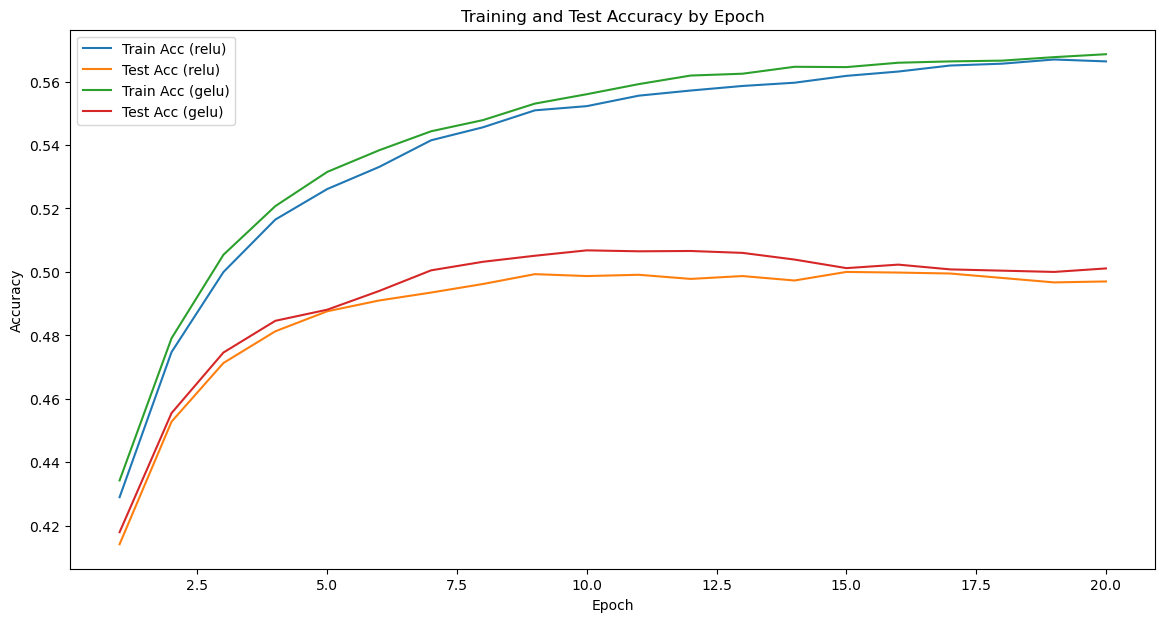

  Activation  Final Accuracy  Execution Time
0       relu          0.4970       48.956785
1       gelu          0.5011       90.763870


In [27]:
# 假设X_train, y_train, X_test, y_test已经定义并准备好了
num_classes = np.unique(y_train).size

# 将训练和测试标签转换为 one-hot 编码
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

# 定义激活函数的搜索范围
activation_functions = ['relu', 'gelu']

# 用于存储每种激活函数的训练和测试准确率数据
accuracy_data = {}
# 用于存储最终准确率和运行时间
final_results = []

for activation in activation_functions:
    print(f"Testing model with activation function: {activation}")
    # 初始化MLP模型，所有隐藏层使用相同的激活函数
    nn = MLP(layers=[X_train.shape[1], 68, 128, num_classes], 
             activations=[None, activation, activation, None], 
             dropout_rates=[0.0, 0.3, 0.0, 0.0])

    start_time = time.time()
    # 训练模型，并收集每个epoch的训练和测试准确率
    losses, train_acc, train_recall, train_f1, train_precision, test_acc, test_recall, test_f1, test_precision = nn.fit(X=X_train, y=y_train_one_hot, y_train=y_train, X_test=X_test, y_test=y_test, learning_rate=0.01, epochs=20, batch_size=32, weight_decay=0.001, momentum=0.9)
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"执行时间: {execution_time}秒")

    # 保存每个epoch的训练和测试准确率
    accuracy_data[activation] = {'train_acc': train_acc, 'test_acc': test_acc}
    # 保存最终准确率和运行时间
    final_results.append({'Activation': activation, 'Final Accuracy': test_acc[-1], 'Execution Time': execution_time})

# 绘制图表
epochs = range(1, 21)  # 假设总共有20个epoch
plt.figure(figsize=(14, 7))

for activation, data in accuracy_data.items():
    plt.plot(epochs, data['train_acc'], label=f'Train Acc ({activation})')
    plt.plot(epochs, data['test_acc'], label=f'Test Acc ({activation})')

plt.title('Training and Test Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 创建对比表格
df = pd.DataFrame(final_results)
print(df)

## 7.3. lr and dr

In [28]:
# 假设X_train, y_train, X_test, y_test已经定义并准备好了
# num_classes = np.unique(y_train).size

# 将训练和测试标签转换为 one-hot 编码
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

# 定义超参数的搜索范围
learning_rates = [0.1,0.01, 0.001]
dropout_rates = [0.0, 0.3, 0.5]  # 假设我们只调整最后一个隐藏层的dropout率

best_accuracy = 0
best_params = {}

# 初始化结果字典
results_lrdr = {}

for lr in learning_rates:
    for dr in dropout_rates:
        print(f"Testing model with learning rate: {lr} and dropout rate: {dr}")
        nn = MLP(layers=[X_train.shape[1], 68, 128, num_classes],
                  activations=[None, 'gelu', 'gelu', None],
                  dropout_rates=[0.0, dr, 0.0, 0.0])

        config_name = f"learning_rate:{lr}_dropout_rate:{dr}"
        
        start_time = time.time()
        # 训练模型
        losses, train_top1_acc_metrics, train_recall_score_metrics, train_f1_score_metrics, train_precision_score_metrics, test_top1_acc_metrics, test_recall_score_metrics, test_f1_score_metrics, test_precision_score_metrics = nn.fit(X=X_train, y=y_train_one_hot, y_train=y_train, X_test=X_test, y_test=y_test, learning_rate=lr, epochs=20, batch_size=32, weight_decay=0.001, momentum=0.9)
        end_time = time.time()

        print(f"执行时间: {end_time - start_time}秒")

        # 计算测试集上的准确率
        y_pred = nn.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        print(f"测试集准确率: {accuracy * 100:.2f}%")

        # 更新最佳参数
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'dropout_rate': dr}
        
        # 保存结果到字典
        results_lrdr[config_name] = {
            'train_accuracy': train_top1_acc_metrics,
            'test_accuracy': test_top1_acc_metrics,
            'execution_time': end_time - start_time,
            'final_test_accuracy': accuracy
        }

print(f"最佳参数: 学习率={best_params['learning_rate']}, Dropout率={best_params['dropout_rate']}")
print(f"最佳测试集准确率: {best_accuracy * 100:.2f}%")

Testing model with learning rate: 0.1 and dropout rate: 0.0
Epoch 1/20: Loss: 1.6790 - Train Accuracy: 0.4974 - Test Accuracy: 0.4735
Epoch 2/20: Loss: 1.4748 - Train Accuracy: 0.5330 - Test Accuracy: 0.4926
Epoch 3/20: Loss: 1.4036 - Train Accuracy: 0.5488 - Test Accuracy: 0.5016
Epoch 4/20: Loss: 1.3632 - Train Accuracy: 0.5585 - Test Accuracy: 0.5016
Epoch 5/20: Loss: 1.3366 - Train Accuracy: 0.5666 - Test Accuracy: 0.5031
Epoch 6/20: Loss: 1.3176 - Train Accuracy: 0.5697 - Test Accuracy: 0.5020
Epoch 7/20: Loss: 1.3034 - Train Accuracy: 0.5727 - Test Accuracy: 0.5004
Epoch 8/20: Loss: 1.2931 - Train Accuracy: 0.5762 - Test Accuracy: 0.4973
Epoch 9/20: Loss: 1.2856 - Train Accuracy: 0.5772 - Test Accuracy: 0.4950
Epoch 10/20: Loss: 1.2801 - Train Accuracy: 0.5787 - Test Accuracy: 0.4955
Epoch 11/20: Loss: 1.2765 - Train Accuracy: 0.5783 - Test Accuracy: 0.4969
Epoch 12/20: Loss: 1.2740 - Train Accuracy: 0.5782 - Test Accuracy: 0.4947
Epoch 13/20: Loss: 1.2725 - Train Accuracy: 0.577

KeyboardInterrupt: 

In [ ]:
print(f"best params: learning_rate={best_params['learning_rate']}, Dropout_rate={best_params['dropout_rate']}")
print(f"best accuracy: {best_accuracy * 100:.2f}%")

In [ ]:
# 假设results_lrdr字典已经按照之前的步骤填充好了数据

# 将结果字典转换为DataFrame
results_df = pd.DataFrame.from_dict(results_lrdr, orient='index')

# 重命名列以更清晰地表示它们的含义
results_df.rename(columns={'train_accuracy': 'Train Accuracy',
                           'test_accuracy': 'Test Accuracy',
                           'execution_time': 'Execution Time (s)',
                           'final_test_accuracy': 'Final Test Accuracy'}, inplace=True)

# 如果Train Accuracy是列表形式，假设您想展示最后一个epoch的准确率
results_df['Train Accuracy'] = results_df['Train Accuracy'].apply(lambda x: x[-1] if isinstance(x, list) else x)

# 如果Test Accuracy是列表形式，计算平均值
results_df['Test Accuracy'] = results_df['Test Accuracy'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

# 将Final Test Accuracy转换为百分比形式
results_df['Final Test Accuracy'] = results_df['Final Test Accuracy'] * 100

# 打印DataFrame
print(results_df)

The design of our best model
hidden layers：2
激活方式：gelu
lr and dr：0.01 0.3
epochs=20, batch_size=32, weight_decay=0.001, momentum=0.9这些参数也进行了微调，但是差别不大，没必要单独再做分析，于是在一开始边固定了这几个参数的值。

## 8.best model 的performance

In [ ]:
num_classes = np.unique(y_train).size

# 将训练和测试标签转换为 one-hot 编码
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

# 初始化 MLP 模型
# 这里我们使用一个输入层、两个隐藏层和一个输出层
# 注意：根据您的 MLP 类的实现，可能需要调整参数名称和方法调用
nn = MLP(layers=[X_train.shape[1],68,128, num_classes], activations=[None,'gelu','gelu',None], dropout_rates=[0.0, 0.3, 0.0, 0.0])


start_time = time.time()
# 训练模型
# 注意：fit 方法的接口可能需要根据您的 MLP 类的实现进行调整
losses,train_top1_acc_metrics,train_recall_score_metrics, train_f1_score_metrics,train_precision_score_metrics,\
test_top1_acc_metrics,test_recall_score_metrics,test_f1_score_metrics, test_precision_score_metrics \
= nn.fit(X=X_train, y=y_train_one_hot,y_train=y_train,X_test=X_test,y_test=y_test, learning_rate=0.01, epochs=50, batch_size=32,weight_decay=0.001, momentum=0.9)
end_time = time.time()

print(f"执行时间: {end_time - start_time}秒")

y_pred = nn.predict(X_train)
accuracy= np.mean(y_pred == y_train)
print(f"训练集准确率: {accuracy * 100:.2f}%")
# 计算测试集上的准确率
# 注意：这里假设 predict 方法返回的是每个样本最可能的类别的索引
# 使用训练好的模型进行预测
y_pred = nn.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"测试集准确率: {accuracy * 100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_top1_acc_metrics) + 1)

fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 9))

# Accuracy
ax[0][0].plot(epochs, train_top1_acc_metrics, color="darkred", label='Train Accuracy')
ax[0][0].plot(epochs, test_top1_acc_metrics, color="darkorange", label='Test Accuracy')
ax[0][0].legend(loc='best')
ax[0][0].set_ylabel("Accuracy", fontsize=12)
ax[0][0].set_xlabel("Epochs", fontsize=12)
ax[0][0].set_title("Accuracy over Epochs", fontsize=14)

# Recall
ax[0][1].plot(epochs, train_recall_score_metrics, color="navy", label='Train Recall')
ax[0][1].plot(epochs, test_recall_score_metrics, color="teal", label='Test Recall')
ax[0][1].legend(loc='best')
ax[0][1].set_ylabel("Recall Score", fontsize=12)
ax[0][1].set_xlabel("Epochs", fontsize=12)
ax[0][1].set_title("Recall Score over Epochs", fontsize=14)

# F1 Score
ax[1][0].plot(epochs, train_f1_score_metrics, color="gold", label='Train F1 Score')
ax[1][0].plot(epochs, test_f1_score_metrics, color="indigo", label='Test F1 Score')
ax[1][0].legend(loc='best')
ax[1][0].set_ylabel("F1 Score", fontsize=12)
ax[1][0].set_xlabel("Epochs", fontsize=12)
ax[1][0].set_title("F1 Score over Epochs", fontsize=14)

# Precision
ax[1][1].plot(epochs, train_precision_score_metrics, color="darkgray", label='Train Precision')
ax[1][1].plot(epochs, test_precision_score_metrics, color="violet", label='Test Precision')
ax[1][1].legend(loc='best')
ax[1][1].set_ylabel("Precision Score", fontsize=12)
ax[1][1].set_xlabel("Epochs", fontsize=12)
ax[1][1].set_title("Precision Score over Epochs", fontsize=14)

fig.suptitle('Model Performance Metrics over Epochs', fontsize=16)

plt.show()

In [ ]:
print(test_top1_acc_metrics,test_recall_score_metrics,test_f1_score_metrics, test_precision_score_metrics)